# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import (accuracy_score, mean_squared_error)

In [105]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Есть пропуски в данных.

Стоит заменить типы данных

### Дубликаты

In [107]:
full_cols=[]
for col in data.columns:
    if data[col].isna().sum()==0:
        full_cols.append(col)

In [108]:
full_cols

['DateCrawled',
 'Price',
 'RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'Brand',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [109]:
#удаляю DateCrawled, DateCreated, LastSeen - даты
full_cols = full_cols[1:7]+full_cols[8:10]

In [110]:
data.duplicated(subset=full_cols).sum()

28901

In [111]:
data = data.drop_duplicates(subset=full_cols, keep='first')

### Пропуски

In [112]:
null_cols=[]
for col in data.columns:
    if data[col].isna().sum()>0:
        null_cols.append(col)

In [113]:
null_cols

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

**Отделение тестовой выборки**

In [114]:
data_full = data[~((data['VehicleType'].isna())|(
    data['Gearbox'].isna())|(data['Model'].isna())|(data['FuelType'].isna())|(data['Repaired'].isna()))]
data_null = data[((data['VehicleType'].isna())|(
    data['Gearbox'].isna())|(data['Model'].isna())|(data['FuelType'].isna())|(data['Repaired'].isna()))]
data_test = data_full.sample(frac=0.25, random_state=12345)
data = pd.concat([data_full.drop(data_test.index,axis=0), data_null])
del data_null
del data_full

**VehicleType**

In [115]:
data.loc[3]

DateCrawled          2016-03-17 16:54:04
Price                               1500
VehicleType                        small
RegistrationYear                    2001
Gearbox                           manual
Power                                 75
Model                               golf
Kilometer                         150000
RegistrationMonth                      6
FuelType                          petrol
Brand                         volkswagen
Repaired                              no
DateCreated          2016-03-17 00:00:00
NumberOfPictures                       0
PostalCode                         91074
LastSeen             2016-03-17 17:40:17
Name: 3, dtype: object

In [116]:
data['VehicleType'].unique()

array(['small', 'convertible', 'sedan', 'wagon', 'bus', 'coupe', 'other',
       'suv', nan], dtype=object)

In [117]:
features_train = data.loc[data[~data['VehicleType'].isna()].index][full_cols]
target_train = data.dropna(subset=['VehicleType'])['VehicleType']

features_test = data.loc[data[data['VehicleType'].isna()].index][full_cols]
target_test = data[data['VehicleType'].isna()]['VehicleType']

In [118]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [119]:
features_train.shape, target_train.shape

((186984, 8), (186984,))

In [120]:
features_test.shape, target_test.shape

((35626, 8), (35626,))

In [121]:
features_valid.shape, target_valid.shape

((46746, 8), (46746,))

In [122]:
model = CatBoostClassifier(loss_function="MultiClass", iterations=50 ,learning_rate=0.7)
model.fit(features_train, target_train, cat_features=['Brand'], verbose=10)
pred_valid = model.predict(features_valid) 

0:	learn: 1.5200848	total: 660ms	remaining: 32.4s
10:	learn: 1.2241125	total: 6.84s	remaining: 24.3s
20:	learn: 1.1729079	total: 13.2s	remaining: 18.3s
30:	learn: 1.1380956	total: 19.4s	remaining: 11.9s
40:	learn: 1.1130504	total: 25.7s	remaining: 5.64s
49:	learn: 1.0967198	total: 31.6s	remaining: 0us


In [123]:
accuracy_score(target_valid,pred_valid)

0.5718564155221837

In [124]:
predictet_values = pd.DataFrame(model.predict(features_test),index=target_test.index)
for i in target_test.index:
    data['VehicleType'].loc[i]=predictet_values[0][i]

**Gearbox**

In [125]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [126]:
features_train = data.loc[data[~data['Gearbox'].isna()].index][full_cols]
target_train = data.dropna(subset=['Gearbox'])['Gearbox']

features_test = data.loc[data[data['Gearbox'].isna()].index][full_cols]
target_test = data[data['Gearbox'].isna()]['Gearbox']

In [127]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [128]:
features_train.shape, target_train.shape

((200642, 8), (200642,))

In [129]:
features_test.shape, target_test.shape

((18553, 8), (18553,))

In [130]:
features_valid.shape, target_valid.shape

((50161, 8), (50161,))

In [131]:
model = CatBoostClassifier(loss_function="Logloss", iterations=50 ,learning_rate=0.7)
model.fit(features_train, target_train, cat_features=['Brand'], verbose=10)
pred_valid = model.predict(features_valid) 

0:	learn: 0.4616954	total: 48.4ms	remaining: 2.37s
10:	learn: 0.3460914	total: 575ms	remaining: 2.04s
20:	learn: 0.3392182	total: 1.12s	remaining: 1.55s
30:	learn: 0.3331223	total: 1.66s	remaining: 1.02s
40:	learn: 0.3298010	total: 2.21s	remaining: 484ms
49:	learn: 0.3285155	total: 2.67s	remaining: 0us


In [132]:
accuracy_score(target_valid,pred_valid)

0.8632603018281135

In [133]:
predictet_values = pd.DataFrame(model.predict(features_test),index=target_test.index)
for i in target_test.index:
    data['Gearbox'].loc[i]=predictet_values[0][i]

**Model**

In [134]:
data['Model'].unique()

array(['golf', 'fabia', '2_reihe', 'other', '3_reihe', 'passat', 'twingo',
       'c_max', 'scirocco', 'civic', 'transporter', 'punto', 'e_klasse',
       '3er', 'clio', '1er', '5er', 'b_klasse', 'astra', 'fortwo', 'a8',
       'jetta', 'polo', 'c_klasse', 'micra', 'sprinter', '156',
       'forester', 'fiesta', 'scenic', 'a1', 'combo', 'tt', 'a6', 'jazz',
       'slk', 'focus', '80', '147', 'meriva', 'z_reihe', 'v40', 'ibiza',
       'mustang', 'eos', 'a4', 'insignia', 'megane', 'a3', 'lupo', 'r19',
       'corsa', 'berlingo', '7er', 'tiguan', 'sharan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'kangoo', '5_reihe', 'yeti', 'octavia',
       'zafira', 'rx_reihe', 'mondeo', '6er', 'fox', 'vectra', 'beetle',
       'a_klasse', 'rio', 'touareg', 'omega', 'cuore', 's_max', 'modus',
       'a2', 'c3', 'getz', 'avensis', 'viano', 'roomster', 'sl', 'kaefer',
       'vito', 'touran', 'cooper', 'leon', 'sportage', 'primera',
       '4_reihe', 'espace', 'galaxy', 'exeo', 's_klasse', 'log

Слишком много классов для предсказания

In [135]:
data['Model'] = data['Model'].fillna('other')

**FuelType**

In [136]:
data['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric',
       nan], dtype=object)

In [137]:
features_train = data.loc[data[~data['FuelType'].isna()].index][full_cols]
target_train = data.dropna(subset=['FuelType'])['FuelType']

features_test = data.loc[data[data['FuelType'].isna()].index][full_cols]
target_test = data[data['FuelType'].isna()]['FuelType']

In [138]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [139]:
features_train.shape, target_train.shape

((190665, 8), (190665,))

In [140]:
features_test.shape, target_test.shape

((31024, 8), (31024,))

In [141]:
features_valid.shape, target_valid.shape

((47667, 8), (47667,))

In [142]:
model = CatBoostClassifier(loss_function="MultiClass", iterations=50 ,learning_rate=0.7)
model.fit(features_train, target_train, cat_features=['Brand'], verbose=10)
pred_valid = model.predict(features_valid) 

0:	learn: 0.7267298	total: 533ms	remaining: 26.1s
10:	learn: 0.4913758	total: 5.79s	remaining: 20.5s
20:	learn: 0.4609716	total: 11s	remaining: 15.3s
30:	learn: 0.4305414	total: 16.7s	remaining: 10.2s
40:	learn: 0.4107348	total: 22.2s	remaining: 4.87s
49:	learn: 0.3995566	total: 27.3s	remaining: 0us


In [143]:
accuracy_score(target_valid,pred_valid)

0.8449451402437745

In [144]:
predictet_values = pd.DataFrame(model.predict(features_test),index=target_test.index)
for i in target_test.index:
    data['FuelType'].loc[i]=predictet_values[0][i]

**Repaired**

In [145]:
data['Repaired'].unique()

array(['no', 'yes', nan], dtype=object)

In [146]:
features_train = data.loc[data[~data['Repaired'].isna()].index][full_cols]
target_train = data.dropna(subset=['Repaired'])['Repaired']

features_test = data.loc[data[data['Repaired'].isna()].index][full_cols]
target_test = data[data['Repaired'].isna()]['Repaired']

In [147]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [148]:
features_train.shape, target_train.shape

((162851, 8), (162851,))

In [149]:
features_test.shape, target_test.shape

((65792, 8), (65792,))

In [150]:
features_valid.shape, target_valid.shape

((40713, 8), (40713,))

In [151]:
model = CatBoostClassifier(loss_function="Logloss", iterations=50 ,learning_rate=0.7)
model.fit(features_train, target_train, cat_features=['Brand'], verbose=10)
pred_valid = model.predict(features_valid) 

0:	learn: 0.4076138	total: 38.3ms	remaining: 1.88s
10:	learn: 0.3033657	total: 462ms	remaining: 1.64s
20:	learn: 0.2972465	total: 888ms	remaining: 1.23s
30:	learn: 0.2937599	total: 1.31s	remaining: 801ms
40:	learn: 0.2913857	total: 1.74s	remaining: 381ms
49:	learn: 0.2899010	total: 2.12s	remaining: 0us


In [152]:
accuracy_score(target_valid,pred_valid)

0.8788838945791271

In [153]:
predictet_values = pd.DataFrame(model.predict(features_test),index=target_test.index)
for i in target_test.index:
    data['Repaired'].loc[i]=predictet_values[0][i]

In [154]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

**Возвращаем тестовую выборку для обработки данных**

In [155]:
data = pd.concat([data, data_test])

### Типы данных

In [156]:
data = data.rename(columns={'Gearbox':'Gearbox_is_auto'})
data = data.rename(columns={'Repaired':'Is_Repaired'})

In [157]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y.%m.%dT%H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y.%m.%dT%H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y.%m.%dT%H:%M:%S')

data['Gearbox_is_auto'] = data['Gearbox_is_auto'].replace('manual',0)
data['Gearbox_is_auto'] = data['Gearbox_is_auto'].replace('auto',1)
data['Gearbox_is_auto']=data['Gearbox_is_auto'].astype('bool')

data['Is_Repaired'] = data['Is_Repaired'].replace('no',0)
data['Is_Repaired'] = data['Is_Repaired'].replace('yes',1)
data['Is_Repaired']=data['Is_Repaired'].astype('bool')

data['VehicleType']=data['VehicleType'].astype('category')
data['Model']=data['Model'].astype('category')
data['FuelType']=data['FuelType'].astype('category')
data['Brand']=data['Brand'].astype('category')

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325468 entries, 3 to 14413
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        325468 non-null  datetime64[ns]
 1   Price              325468 non-null  int64         
 2   VehicleType        325468 non-null  category      
 3   RegistrationYear   325468 non-null  int64         
 4   Gearbox_is_auto    325468 non-null  bool          
 5   Power              325468 non-null  int64         
 6   Model              325468 non-null  category      
 7   Kilometer          325468 non-null  int64         
 8   RegistrationMonth  325468 non-null  int64         
 9   FuelType           325468 non-null  category      
 10  Brand              325468 non-null  category      
 11  Is_Repaired        325468 non-null  bool          
 12  DateCreated        325468 non-null  datetime64[ns]
 13  NumberOfPictures   325468 non-null  int64    

Дубликаты удалены, пропуски заполнены, типы данных изменены.

###  Аномалии

In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325468 entries, 3 to 14413
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        325468 non-null  datetime64[ns]
 1   Price              325468 non-null  int64         
 2   VehicleType        325468 non-null  category      
 3   RegistrationYear   325468 non-null  int64         
 4   Gearbox_is_auto    325468 non-null  bool          
 5   Power              325468 non-null  int64         
 6   Model              325468 non-null  category      
 7   Kilometer          325468 non-null  int64         
 8   RegistrationMonth  325468 non-null  int64         
 9   FuelType           325468 non-null  category      
 10  Brand              325468 non-null  category      
 11  Is_Repaired        325468 non-null  bool          
 12  DateCreated        325468 non-null  datetime64[ns]
 13  NumberOfPictures   325468 non-null  int64    

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


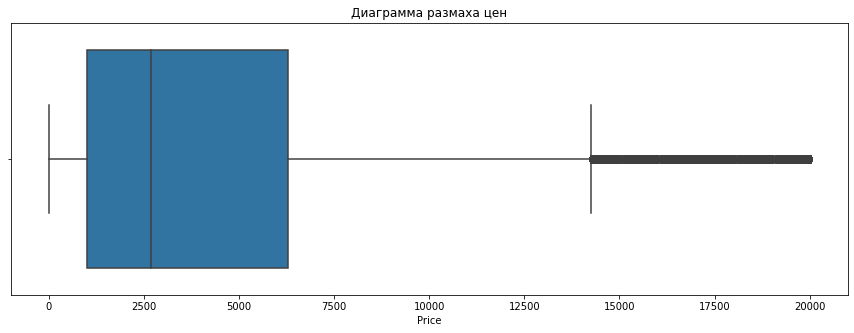

In [160]:
plt.figure(figsize=(15,5))
sns.boxplot(data['Price'])
plt.title('Диаграмма размаха цен');

In [161]:
data = data[data['Price']!=0]

Цены варьируются в диапазодне до 20000, но поскольку это целевой признак удалим только нулевые значения

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


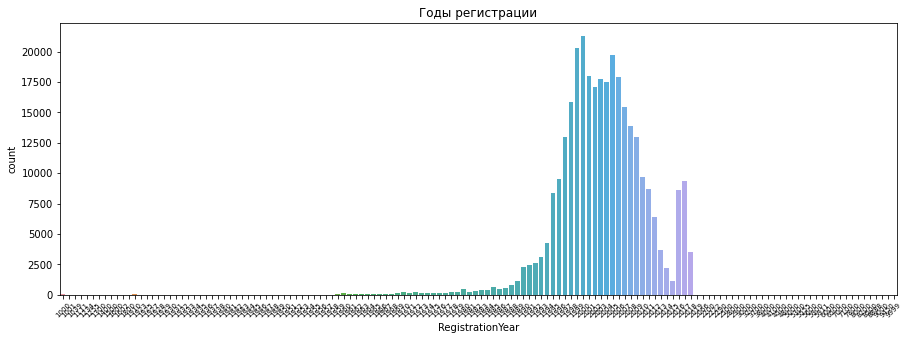

In [162]:
plt.figure(figsize=(15,5))
sns.countplot(data['RegistrationYear'])
plt.xticks(rotation=45, fontsize=7)
plt.title('Годы регистрации');

In [163]:
data[data['RegistrationYear']<1980]['RegistrationYear'].count()

3038

In [164]:
data[data['RegistrationYear']>2016]['RegistrationYear'].count()

13008

In [165]:
data = data[(data['RegistrationYear']>1980)&(data['RegistrationYear']<2016)]

In [166]:
data['LastSeen'].max()

Timestamp('2016-04-07 14:58:51')

Год регистрации не может быть больше даты последней активности пользователя, а автомобили старше 80-го года будем считать аномалией

In [167]:
data[data['Power']>250].count()

DateCrawled          6237
Price                6237
VehicleType          6237
RegistrationYear     6237
Gearbox_is_auto      6237
Power                6237
Model                6237
Kilometer            6237
RegistrationMonth    6237
FuelType             6237
Brand                6237
Is_Repaired          6237
DateCreated          6237
NumberOfPictures     6237
PostalCode           6237
LastSeen             6237
dtype: int64

In [168]:
data[data['Power']<50].count()

DateCrawled          32096
Price                32096
VehicleType          32096
RegistrationYear     32096
Gearbox_is_auto      32096
Power                32096
Model                32096
Kilometer            32096
RegistrationMonth    32096
FuelType             32096
Brand                32096
Is_Repaired          32096
DateCreated          32096
NumberOfPictures     32096
PostalCode           32096
LastSeen             32096
dtype: int64

In [169]:
data = data[(data['Power']<250)&(data['Power']>50)]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


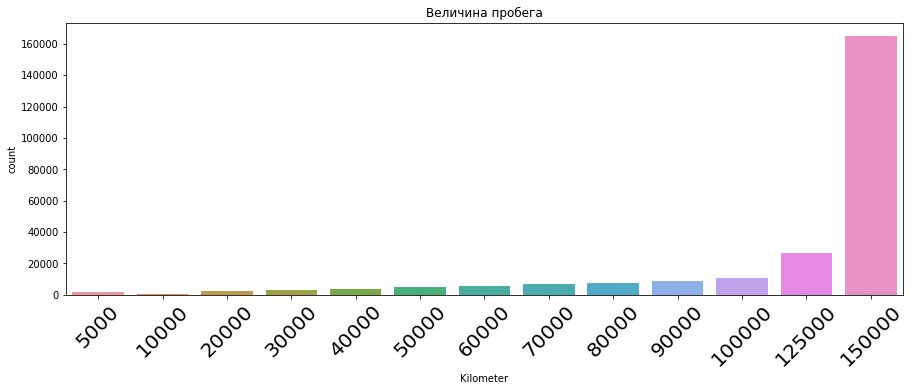

In [170]:
plt.figure(figsize=(15,5))
sns.countplot(data['Kilometer'])
plt.xticks(rotation=45, fontsize=20)
plt.title('Величина пробега');

In [171]:
data['RegistrationMonth'].unique()

array([ 6,  7,  8, 12,  2,  4, 11,  3,  1,  5, 10,  0,  9])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


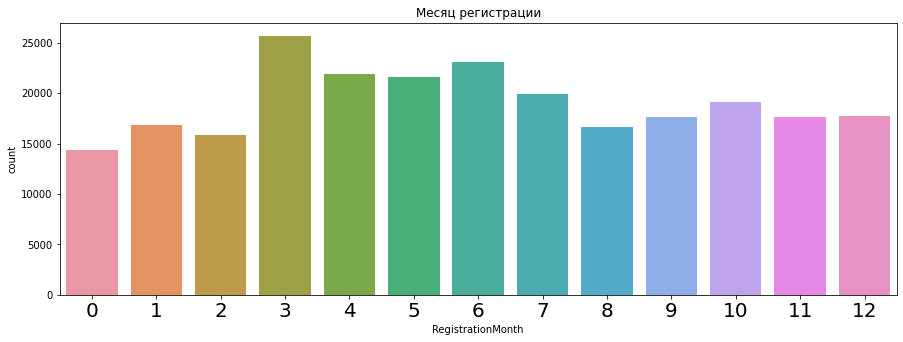

In [172]:
plt.figure(figsize=(15,5))
sns.countplot(data['RegistrationMonth'])
plt.xticks(fontsize=20)
plt.title('Месяц регистрации');

Будем считать,что 0 - месяц не указан

In [173]:
data['NumberOfPictures'].value_counts()

0    247926
Name: NumberOfPictures, dtype: int64

Признак бесполезен

### Выбор признаков

In [174]:
data['Model'].unique()

['golf', 'fabia', '2_reihe', '3_reihe', 'passat', ..., 'rangerover', 'kappa', 'm_reihe', '911', 'serie_2']
Length: 246
Categories (246, object): ['golf', 'fabia', '2_reihe', '3_reihe', ..., 'kappa', 'm_reihe', '911', 'serie_2']

In [176]:
test_index =[]
for i in data_test.index:
    if i in data.index:
        test_index.append(i)

In [178]:
features_train = data.drop(test_index, axis=0)[['VehicleType','RegistrationYear','Gearbox_is_auto','Power',\
                'Kilometer','FuelType','Brand','Is_Repaired']]
target_train = data.drop(test_index, axis=0)['Price']

features_test = data.loc[test_index][['VehicleType','RegistrationYear','Gearbox_is_auto','Power',\
                'Kilometer','FuelType','Brand','Is_Repaired']]
target_test = data.loc[test_index]['Price']

In [179]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [180]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

In [181]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape

((158261, 57), (39566, 57), (50099, 57), (158261,), (39566,), (50099,))

Дата скачивания анкеты,  месяц регистрации автомобиля, дата создания анкеты, количество фотографий, почтовый индекс, дата последней активности не должны оказывать ощутимого влияния на цену автомобиля.

Тип кузова, год регистрации, тип коробки передач, мощность, модель, пробег, тип топлива, марка, была ли машина в ремонте могут влиять на цену автомобиля.

Цена - целевой признак.

## Обучение моделей

### **LightGBM**

In [190]:
data_train = lgb.Dataset(features_train, label=target_train)
data_valid = lgb.Dataset(features_valid, label=target_valid)
data_test = lgb.Dataset(features_test, label=target_test)

In [191]:
parameters = {'objective':'regression',
              'metric':'rmse',
             'learning_rate':'0.5',
             'boosting':'gbdt'}

In [192]:
%%time
model_lgbm = lgb.train(parameters,data_train,valid_sets=data_valid, num_boost_round=15,
                       verbose_eval=10, early_stopping_rounds=4)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.719100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 158261, number of used features: 55
[LightGBM] [Info] Start training from score 4702.144091
Training until validation scores don't improve for 4 rounds
[10]	valid_0's rmse: 1681.51
Did not meet early stopping. Best iteration is:
[15]	valid_0's rmse: 1629.3
CPU times: user 15.2 s, sys: 185 ms, total: 15.4 s
Wall time: 15.4 s


In [193]:
parameters = {'objective':'regression',
              'metric':'rmse',
             'learning_rate':'0.5',
             'boosting':'goss'}

In [194]:
%%time
model_lgbm = lgb.train(parameters,data_train,valid_sets=data_valid, num_boost_round=15,
                       verbose_eval=10, early_stopping_rounds=4)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.710855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 158261, number of used features: 55
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4702.144091
Training until validation scores don't improve for 4 rounds
[10]	valid_0's rmse: 1673.8
Did not meet early stopping. Best iteration is:
[15]	valid_0's rmse: 1628.63
CPU times: user 14.8 s, sys: 31 ms, total: 14.8 s
Wall time: 14.8 s


'boosting':'gbdt' быстрее и точнее

In [195]:
parameters = {'objective':'regression',
              'metric':'rmse',
             'learning_rate':'0.2',
             'boosting':'gbdt'}

In [196]:
%%time
model_lgbm = lgb.train(parameters,data_train,valid_sets=data_valid, num_boost_round=15,
                       verbose_eval=10, early_stopping_rounds=4)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 158261, number of used features: 55
[LightGBM] [Info] Start training from score 4702.144091
Training until validation scores don't improve for 4 rounds
[10]	valid_0's rmse: 1910.23
Did not meet early stopping. Best iteration is:
[15]	valid_0's rmse: 1743.96
CPU times: user 13.2 s, sys: 20.3 ms, total: 13.3 s
Wall time: 13.3 s


Снижение скорости обучения сильно замедлило алгоритм, разница в rmse - всего 3%

### **LinearRegression**

In [197]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 1.47 s, sys: 920 ms, total: 2.39 s
Wall time: 2.4 s


LinearRegression()

In [198]:
predictions=model.predict(features_valid)
mean_squared_error(target_valid, predictions, squared=False)

2408.6815607882795

Высокая скорость, но едва пройден порог метрики rmse в 2500

### **CatBoostRegressor**

In [199]:
%%time
model_catboost = CatBoostRegressor(iterations=100, 
                          depth=10, 
                          learning_rate=0.5, 
                          loss_function='RMSE')
model_catboost.fit(features_train, target_train, verbose=10, early_stopping_rounds=4)

0:	learn: 2938.7842889	total: 34.2ms	remaining: 3.39s
10:	learn: 1647.4787374	total: 422ms	remaining: 3.42s
20:	learn: 1573.9440478	total: 818ms	remaining: 3.08s
30:	learn: 1525.7830733	total: 1.21s	remaining: 2.69s
40:	learn: 1499.3806791	total: 1.61s	remaining: 2.31s
50:	learn: 1472.5840806	total: 2s	remaining: 1.92s
60:	learn: 1455.0451251	total: 2.37s	remaining: 1.52s
70:	learn: 1435.2584527	total: 2.76s	remaining: 1.13s
80:	learn: 1422.2461036	total: 3.13s	remaining: 735ms
90:	learn: 1407.8956113	total: 3.51s	remaining: 348ms
99:	learn: 1396.5789265	total: 3.87s	remaining: 0us
CPU times: user 4.23 s, sys: 53.4 ms, total: 4.28 s
Wall time: 4.97 s


In [200]:
%%time
pred_valid = model_catboost.predict(features_valid)

CPU times: user 56.9 ms, sys: 13 µs, total: 56.9 ms
Wall time: 54.9 ms


In [201]:
mean_squared_error(target_valid, pred_valid, squared=False)

1509.6723363638425

In [202]:
%%time
model_catboost = CatBoostRegressor(iterations=100, 
                          depth=10, 
                          learning_rate=0.1, 
                          loss_function='RMSE')
model_catboost.fit(features_train, target_train, verbose=10, early_stopping_rounds=4)

0:	learn: 4139.6483195	total: 40.3ms	remaining: 3.99s
10:	learn: 2372.0897794	total: 408ms	remaining: 3.3s
20:	learn: 1886.1909927	total: 790ms	remaining: 2.97s
30:	learn: 1739.7131528	total: 1.17s	remaining: 2.6s
40:	learn: 1674.5558844	total: 1.53s	remaining: 2.21s
50:	learn: 1643.6447723	total: 1.91s	remaining: 1.83s
60:	learn: 1620.3428249	total: 2.27s	remaining: 1.45s
70:	learn: 1602.4605577	total: 2.64s	remaining: 1.08s
80:	learn: 1587.9766542	total: 3.02s	remaining: 708ms
90:	learn: 1574.3275192	total: 3.4s	remaining: 336ms
99:	learn: 1562.2938258	total: 3.75s	remaining: 0us
CPU times: user 4.15 s, sys: 20.3 ms, total: 4.17 s
Wall time: 4.74 s


In [203]:
%%time
pred_valid = model_catboost.predict(features_valid) 

CPU times: user 58.2 ms, sys: 0 ns, total: 58.2 ms
Wall time: 57.5 ms


In [204]:
mean_squared_error(target_valid, pred_valid, squared=False)

1573.176250656124

похоже модель переобучилась

In [205]:
%%time
model_catboost = CatBoostRegressor(iterations=100, 
                          depth=16, 
                          learning_rate=0.75, 
                          loss_function='RMSE')
model_catboost.fit(features_train, target_train, verbose=10, early_stopping_rounds=4)

0:	learn: 2316.9342174	total: 555ms	remaining: 54.9s
10:	learn: 1493.6112448	total: 5.79s	remaining: 46.9s
20:	learn: 1400.2313096	total: 11s	remaining: 41.3s
30:	learn: 1337.6984588	total: 16.3s	remaining: 36.2s
40:	learn: 1296.2970320	total: 21.4s	remaining: 30.8s
50:	learn: 1266.7367010	total: 26.4s	remaining: 25.4s
60:	learn: 1241.8139744	total: 31.3s	remaining: 20s
70:	learn: 1223.0782854	total: 35.9s	remaining: 14.7s
80:	learn: 1202.1527995	total: 40.8s	remaining: 9.58s
90:	learn: 1188.3644301	total: 45.8s	remaining: 4.53s
99:	learn: 1177.7186287	total: 50.4s	remaining: 0us
CPU times: user 37.5 s, sys: 13.7 s, total: 51.2 s
Wall time: 52 s


In [206]:
%%time
pred_valid = model_catboost.predict(features_valid) 

CPU times: user 71.4 ms, sys: 29 µs, total: 71.4 ms
Wall time: 74.9 ms


In [207]:
mean_squared_error(target_valid, pred_valid, squared=False)

1533.8772998621544

Увеличение глубины слишком сильно замедлило модель

## Анализ моделей

In [208]:
parameters = {'objective':'regression',
              'metric':'rmse',
             'learning_rate':'0.5',
             'boosting':'gbdt'}

In [215]:
%%time
model_best_lgbm = lgb.train(parameters,data_train,valid_sets=data_valid, num_boost_round=15,
                       verbose_eval=10, early_stopping_rounds=4)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 158261, number of used features: 55
[LightGBM] [Info] Start training from score 4702.144091
Training until validation scores don't improve for 4 rounds
[10]	valid_0's rmse: 1681.51
Did not meet early stopping. Best iteration is:
[15]	valid_0's rmse: 1629.3
CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s


In [216]:
%%time
model_best_catboost = CatBoostRegressor(iterations=100, 
                          depth=10, 
                          learning_rate=0.5, 
                          loss_function='RMSE')
model_best_catboost.fit(features_train, target_train, verbose=10, early_stopping_rounds=4)

0:	learn: 2938.7842889	total: 35.6ms	remaining: 3.52s
10:	learn: 1647.4787374	total: 439ms	remaining: 3.55s
20:	learn: 1573.9440478	total: 816ms	remaining: 3.07s
30:	learn: 1525.7830733	total: 1.2s	remaining: 2.66s
40:	learn: 1499.3806791	total: 1.57s	remaining: 2.26s
50:	learn: 1472.5840806	total: 1.97s	remaining: 1.89s
60:	learn: 1455.0451251	total: 2.35s	remaining: 1.5s
70:	learn: 1435.2584527	total: 2.74s	remaining: 1.12s
80:	learn: 1422.2461036	total: 3.12s	remaining: 732ms
90:	learn: 1407.8956113	total: 3.5s	remaining: 347ms
99:	learn: 1396.5789265	total: 3.85s	remaining: 0us
CPU times: user 4.22 s, sys: 10.9 ms, total: 4.23 s
Wall time: 5.34 s


In [217]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 1.32 s, sys: 594 ms, total: 1.92 s
Wall time: 1.89 s


LinearRegression()

In [218]:
%%time
predictions_lgbm = model_best_lgbm.predict(features_test)

CPU times: user 373 ms, sys: 50.8 ms, total: 424 ms
Wall time: 415 ms


In [224]:
%%time
predictions_catboost = model_best_catboost.predict(features_test) 

CPU times: user 99.4 ms, sys: 49 µs, total: 99.5 ms
Wall time: 97.5 ms


In [225]:
%%time
predictions_lr=model_lr.predict(features_test)

CPU times: user 166 ms, sys: 249 µs, total: 167 ms
Wall time: 166 ms


In [226]:
'LightGBM', mean_squared_error(target_test, predictions_lgbm, squared=False)

('LightGBM', 1676.1943030900886)

In [227]:
'CatBoostRegressor', mean_squared_error(target_test, predictions_catboost, squared=False)

('CatBoostRegressor', 1552.6812185328777)

In [228]:
'LinearRegression', mean_squared_error(target_test, predictions_lr, squared=False)

('LinearRegression', 2443.949961178505)

Лучшее Wall time - LinearRegression, но ее предсказания наименее точны.

LightGBM имеет лучший показатель rmse: 1676

CatBoost: показатель rmse: 1552

Время предсказаний незначительно у всех моделей

Лучшая модель - CatBoost